In [1]:
import sys
sys.path.append("../..")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from surgeNN.evaluation import add_error_metrics_to_prediction_ds
import matplotlib
import os
from surgeNN import io

In [2]:
#configure the script
tgs        = ['den_helder-denhdr-nld-rws.csv']
qnts = np.array([.95,.98,.99,.995]) #quantiles, don't touch

max_timesteps_between_extremes = 3

load hadgem3 trained:

In [3]:
ds1 = io.Output('/home/jovyan/test_surge_models/results/nns_hadgem3/performance/lstm/')
ds1.open_performance_data(tgs)
ds1.data = ds1.data.sel(max_timesteps_between_extremes=3).load()

observed_thresholds = ds1.observed_thresholds()
ds1 = ds1.data

load codec trained hadgem3 forced:

In [4]:
predictions_path = '/home/jovyan/test_surge_models/results/nns_hadgem3/codec_trained_predictions'
predictions = []
for it in np.arange(10):
    fns = [os.path.join(predictions_path,k) for k in os.listdir(predictions_path) if 'it'+str(it) in k]
    i = [int(k.split('_')[-2].replace('i','')) for k in fns]
    ds = xr.open_mfdataset(fns,concat_dim='i',combine='nested')
    ds = ds.assign_coords({'i':i})
    predictions.append(ds)
predictions_ds = xr.concat(predictions,dim='it').load()
predictions_ds = xr.concat([predictions_ds.sel(time=slice('1951','2014')),predictions_ds.sel(time=slice('2016','2050'))],dim='time',data_vars='minimal') #no GTSM simulations for 1950/part of 2015?


#convert time calendar to stretched coordinates:
gtsm=io.Predictand('/home/jovyan/test_surge_models/input/GTSM_HighResMIP_HadGEM3-GC31-HM_at_gesla3_tgs_stretched_3hourly_rounded10min_after2.nc')
gtsm.open_dataset(tgs[0])
gtsm.deseasonalize()
gtsm.data = gtsm.data[(gtsm.data.date.dt.year.isin([1950,2015])==False)] #without these years, timesteps should align?


predictions_ds = predictions_ds.assign_coords({'time':gtsm.data.date.values})
predictions_ds['o'] = (('time'),gtsm.data.surge.values) #add observations

#divide over the different splits
predictions_ds = predictions_ds.sel(time=ds1.time.values)
predictions_ds['o'] = predictions_ds.o.expand_dims({'split':3},axis=-1).where(np.isfinite(ds1.o.isel(it=0)))
predictions_ds['yhat'] = predictions_ds.yhat.expand_dims({'split':3},axis=-1).where(np.isfinite(ds1.o.isel(it=0)))

load codec trained:

In [5]:
ds = io.Output('/home/jovyan/test_surge_models/results/nns_codec/performance/lstm/')
ds.open_performance_data(tgs)
ds.data = ds.data.sel(max_timesteps_between_extremes=3).load()

observed_thresholds_codec = ds.observed_thresholds()
ds = ds.data

In [6]:
#add performance
predictions_ds = add_error_metrics_to_prediction_ds(predictions_ds,[.95,.98,.99,.995],3) #currently doesn't consider splits, does this work?

In [7]:
ds1

<xarray.Dataset>
Dimensions:                         (time: 284914, tg: 1, p: 10, it: 10,
                                     split: 3, i: 3, e: 100, quantile: 4)
Coordinates:
  * time                            (time) datetime64[ns] 1951-01-01 ... 2050...
  * tg                              (tg) <U29 'den_helder-denhdr-nld-rws.csv'
  * p                               (p) object 'batch_size' ... 'dl_alpha'
  * split                           (split) object 'train' 'val' 'test'
  * quantile                        (quantile) float64 0.95 0.98 0.99 0.995
    max_timesteps_between_extremes  int64 3
    lon                             (tg) float64 4.745
    lat                             (tg) float64 52.96
Dimensions without coordinates: it, i, e
Data variables: (12/16)
    o                               (it, split, time, tg) float64 -0.2645 ......
    yhat                            (it, i, split, time, tg) float64 -0.2833 ...
    hyperparameters                 (tg, it, i, split, p) float64 128.0 ... 3.0
    loss                            (tg, it, i, e) float64 0.5657 0.4192 ... nan
    val_loss                        (tg, it, i, e) float64 0.4387 0.3919 ... nan
    r_bulk                          (it, i, split, tg) float64 0.8683 ... 0.7566
    ...                              ...
    false_neg                       (it, i, split, tg, quantile) float64 3.37...
    false_pos                       (it, i, split, tg, quantile) float64 1.75...
    true_neg                        (it, i, split, tg, quantile) float64 1.60...
    precision                       (it, i, split, tg, quantile) float64 0.72...
    recall                          (it, i, split, tg, quantile) float64 0.57...
    f1                              (it, i, split, tg, quantile) float64 0.63...
Attributes:
    description:      lstm - neural network prediction performance.
    loss_function:    mse
    temp_freq:        3
    n_cells:          12
    n_epochs:         100
    patience:         10
    split_fractions:  [0.6 0.2 0.2]
    stratification:   99pct_7_0
    predictor_vars:   ['msl', 'u10', 'v10']

In [8]:
ds

<xarray.Dataset>
Dimensions:                         (time: 113928, tg: 1, p: 10, it: 10,
                                     split: 3, i: 3, e: 100, quantile: 4)
Coordinates:
  * time                            (time) datetime64[ns] 1979-01-02 ... 2017...
  * tg                              (tg) <U29 'den_helder-denhdr-nld-rws.csv'
  * p                               (p) object 'batch_size' ... 'dl_alpha'
  * split                           (split) object 'train' 'val' 'test'
  * quantile                        (quantile) float64 0.95 0.98 0.99 0.995
    max_timesteps_between_extremes  int64 3
    lon                             (tg) float64 4.745
    lat                             (tg) float64 52.96
Dimensions without coordinates: it, i, e
Data variables: (12/16)
    o                               (it, split, time, tg) float64 nan ... 0.3618
    yhat                            (it, i, split, time, tg) float64 nan ... ...
    hyperparameters                 (tg, it, i, split, p) float64 128.0 ... 3.0
    loss                            (tg, it, i, e) float64 0.4834 0.3094 ... nan
    val_loss                        (tg, it, i, e) float64 0.322 0.2563 ... nan
    r_bulk                          (it, i, split, tg) float64 0.9379 ... 0.8391
    ...                              ...
    false_neg                       (it, i, split, tg, quantile) float64 738....
    false_pos                       (it, i, split, tg, quantile) float64 713....
    true_neg                        (it, i, split, tg, quantile) float64 6.61...
    precision                       (it, i, split, tg, quantile) float64 0.78...
    recall                          (it, i, split, tg, quantile) float64 0.77...
    f1                              (it, i, split, tg, quantile) float64 0.77...
Attributes:
    description:      lstm - neural network prediction performance.
    loss_function:    mse
    temp_freq:        3
    n_cells:          12
    n_epochs:         100
    patience:         10
    split_fractions:  [0.6 0.2 0.2]
    stratification:   99pct_7_0
    predictor_vars:   ['msl', 'u10', 'v10']

In [9]:
ds.hyperparameters.isel(tg=0,it=0,split=0)

<xarray.DataArray 'hyperparameters' (i: 3, p: 10)>
array([[1.28e+02, 9.00e+00, 1.00e+00, 3.20e+01, 2.00e+00, 3.20e+01,
        1.00e-01, 5.00e-05, 2.00e-02, 0.00e+00],
       [1.28e+02, 9.00e+00, 1.00e+00, 3.20e+01, 2.00e+00, 3.20e+01,
        1.00e-01, 5.00e-05, 2.00e-02, 1.00e+00],
       [1.28e+02, 9.00e+00, 1.00e+00, 3.20e+01, 2.00e+00, 3.20e+01,
        1.00e-01, 5.00e-05, 2.00e-02, 3.00e+00]])
Coordinates:
    tg                              <U29 'den_helder-denhdr-nld-rws.csv'
  * p                               (p) object 'batch_size' ... 'dl_alpha'
    split                           <U5 'train'
    max_timesteps_between_extremes  int64 3
    lon                             float64 4.745
    lat                             float64 52.96
Dimensions without coordinates: i

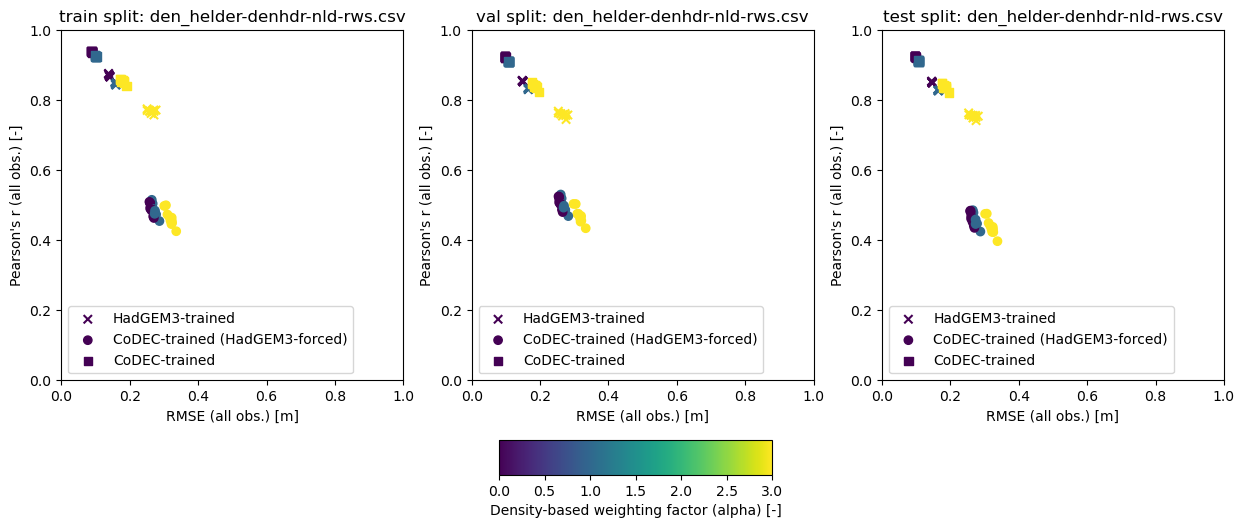

In [11]:
fig=plt.figure(figsize=(15,10))

tg = 'den_helder-denhdr-nld-rws.csv'
out_q = .99


split='train'

ax1 = plt.subplot(2, 3, 1)
s=ax1.scatter(ds1.sel(tg=tg).rmse_bulk.sel(split=split),
            ds1.sel(tg=tg).r_bulk.sel(split=split),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax1.scatter(predictions_ds.sel(tg=tg).rmse_bulk.sel(split=split),
            predictions_ds.sel(tg=tg).r_bulk.sel(split=split),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax1.scatter(ds.sel(tg=tg).rmse_bulk.sel(split=split),
            ds.sel(tg=tg).r_bulk.sel(split=split),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax1.colorbar(s)    
ax1.legend()
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('RMSE (all obs.) [m]')
ax1.set_ylabel("Pearson's r (all obs.) [-]")
ax1.set_title(split +' split: '+tg)


split='val'

ax2 = plt.subplot(2, 3, 2)
s=ax2.scatter(ds1.sel(tg=tg).rmse_bulk.sel(split=split),
            ds1.sel(tg=tg).r_bulk.sel(split=split),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax2.scatter(predictions_ds.sel(tg=tg).rmse_bulk.sel(split=split),
            predictions_ds.sel(tg=tg).r_bulk.sel(split=split),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax2.scatter(ds.sel(tg=tg).rmse_bulk.sel(split=split),
            ds.sel(tg=tg).r_bulk.sel(split=split),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax2.colorbar(s)    
ax2.legend()
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel('RMSE (all obs.) [m]')
ax2.set_ylabel("Pearson's r (all obs.) [-]")
ax2.set_title(split +' split: '+tg)



split='test'

ax3 = plt.subplot(2, 3, 3)
s=ax3.scatter(ds1.sel(tg=tg).rmse_bulk.sel(split=split),
            ds1.sel(tg=tg).r_bulk.sel(split=split),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax3.scatter(predictions_ds.sel(tg=tg).rmse_bulk.sel(split=split),
            predictions_ds.sel(tg=tg).r_bulk.sel(split=split),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax3.scatter(ds.sel(tg=tg).rmse_bulk.sel(split=split),
            ds.sel(tg=tg).r_bulk.sel(split=split),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax3.colorbar(s)    
ax3.legend()
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.set_xlabel('RMSE (all obs.) [m]')
ax3.set_ylabel("Pearson's r (all obs.) [-]")
ax3.set_title(split +' split: '+tg)



cax=inset_axes(ax2,width="100%", height="100%",bbox_to_anchor=(1.3, -.25,.8,.1),bbox_transform=ax1.transAxes)
fig.colorbar(s, cax=cax,orientation='horizontal',label='Density-based weighting factor (alpha) [-]')


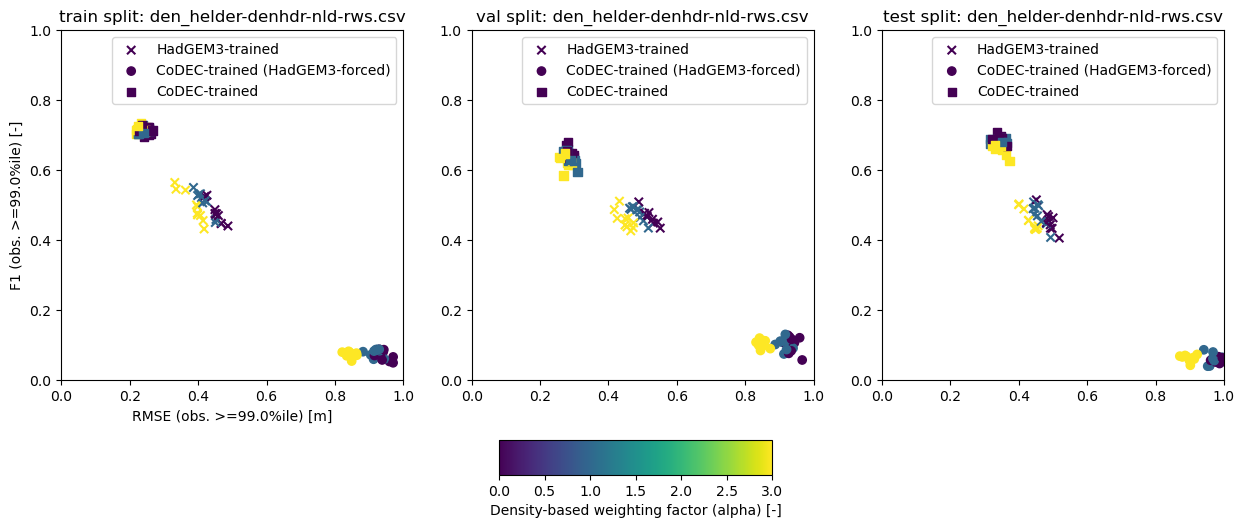

In [12]:
fig=plt.figure(figsize=(15,10))

tg = 'den_helder-denhdr-nld-rws.csv'
out_q = .99


split='train'

ax1 = plt.subplot(2, 3, 1)
s=ax1.scatter(ds1.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds1.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax1.scatter(predictions_ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            predictions_ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax1.scatter(ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds_codec.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax1.colorbar(s)    
ax1.legend()
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('RMSE (obs. >='+str(100*out_q)+'%ile) [m]')
ax1.set_ylabel('F1 (obs. >='+str(100*out_q)+'%ile) [-]')
ax1.set_title(split +' split: '+tg)


split='val'

ax2 = plt.subplot(2, 3, 2)
s=ax2.scatter(ds1.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds1.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax2.scatter(predictions_ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            predictions_ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax2.scatter(ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds_codec.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax2.colorbar(s)    
ax2.legend()
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax1.set_xlabel('RMSE (obs. >='+str(100*out_q)+'%ile) [m]')
ax1.set_ylabel('F1 (obs. >='+str(100*out_q)+'%ile) [-]')
ax2.set_title(split +' split: '+tg)



split='test'

ax3 = plt.subplot(2, 3, 3)
s=ax3.scatter(ds1.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds1.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax3.scatter(predictions_ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            predictions_ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax3.scatter(ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds_codec.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax3.colorbar(s)    
ax3.legend()
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax1.set_xlabel('RMSE (obs. >='+str(100*out_q)+'%ile) [m]')
ax1.set_ylabel('F1 (obs. >='+str(100*out_q)+'%ile) [-]')
ax3.set_title(split +' split: '+tg)



cax=inset_axes(ax2,width="100%", height="100%",bbox_to_anchor=(1.3, -.25,.8,.1),bbox_transform=ax1.transAxes)
fig.colorbar(s, cax=cax,orientation='horizontal',label='Density-based weighting factor (alpha) [-]')


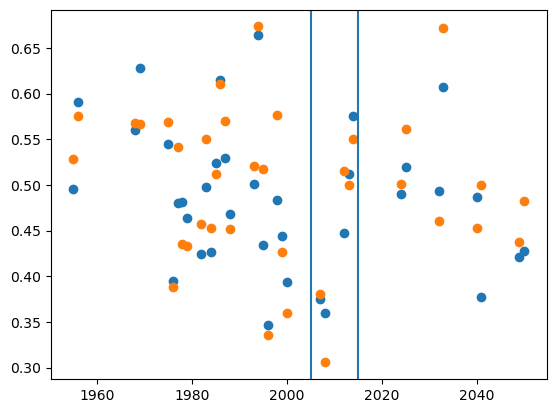

In [16]:
from surgeNN.evaluation import r_pearson_finite
pcts_yhat=[]
pcts_o = []
split='test'
years = np.arange(1950,2051)
for year in years:

    pcts_yhat.append(np.nanpercentile(ds1.yhat.sel(time=slice(str(year),str(year))).isel(tg=0,it=0,i=1).sel(split=split).values,95))
    pcts_o.append(np.nanpercentile(ds1.o.sel(time=slice(str(year),str(year))).isel(tg=0,it=0).sel(split=split).values,95))
plt.scatter(years,pcts_yhat)
plt.scatter(years,pcts_o)
plt.axvline(x=2015)
plt.axvline(x=2015-10)

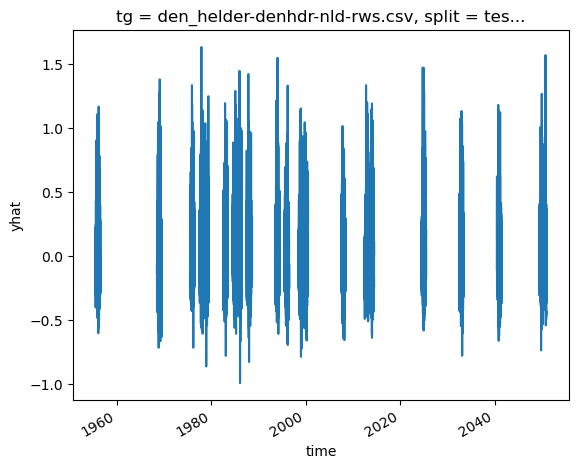

In [20]:
ds1.yhat.isel(tg=0,it=0,i=1).sel(split=split).plot()

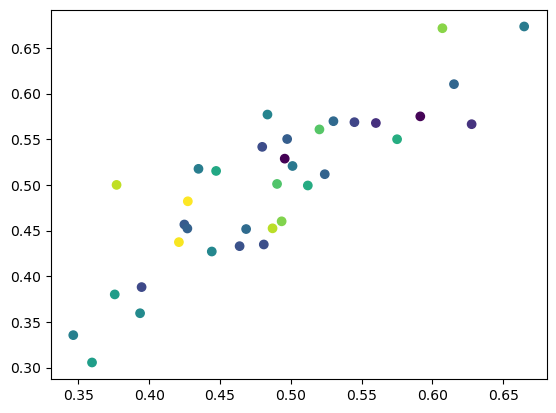

In [17]:
plt.scatter(pcts_yhat,pcts_o,c=years)

In [99]:
r_pearson_finite(np.array(pcts_yhat),np.array(pcts_o))

0.7899882967511713

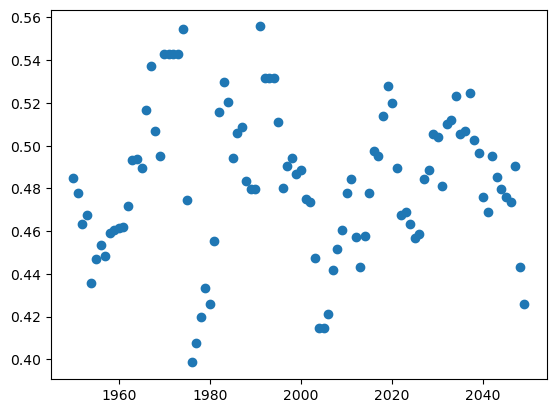

In [68]:
from surgeNN.evaluation import r_pearson_finite
corrs = []
years = np.arange(1950,2051)
for year in years:

    corrs.append(r_pearson_finite(predictions_ds.yhat.sel(time=slice(str(year),str(year))).isel(split=0,tg=0,it=0,i=0).values,
                     predictions_ds.o.sel(time=slice(str(year),str(year))).isel(split=0,tg=0).values))
plt.scatter(years,corrs)
    